In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tqdm import tqdm
import joblib
import warnings
from sklearn.metrics import precision_recall_curve
import torch.nn.functional as F
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')

In [2]:
def apply_smote_sampling(X_train, y_train, sampling_strategy=0.3):
    """SMOTE를 사용한 오버샘플링"""
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print(f"리샘플링 전: {len(y_train)} → 리샘플링 후: {len(y_resampled)}")
    print(f"사기 비율: {y_train.mean():.3f} → {y_resampled.mean():.3f}")
    return X_resampled, y_resampled

In [3]:
class EnhancedCustomerAwareEnsemble(nn.Module):
    """고객 정보를 활용한 향상된 앙상블 모델"""
    
    def __init__(self, customer_dim, card_dim, risk_dim, ensemble_dim=6, hidden_dim=256):
        super().__init__()
        

        # 고객 정보 처리 네트워크
        self.customer_network = nn.Sequential(
            nn.Linear(customer_dim, hidden_dim),  # 22 -> 256
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2)
        )
        
        # 카드 정보 처리 네트워크
        self.card_network = nn.Sequential(
            nn.Linear(card_dim, hidden_dim),  # 14 -> 256
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2)
        )
        
        # 리스크 정보 처리 네트워크
        self.risk_network = nn.Sequential(
            nn.Linear(risk_dim, hidden_dim // 2),  # 2 -> 128
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(0.2)
        )
        
        # 앙상블 예측 처리
        self.ensemble_network = nn.Sequential(
            nn.Linear(ensemble_dim, hidden_dim // 2),  # 6 -> 128
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2)
        )
        
        # 통합 네트워크
        combined_dim = (hidden_dim // 2) * 4  # 128 * 4 = 512
        self.fusion_network = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  
        )
    
    def forward(self, x_customer, x_card, x_risk, x_ensemble):
        customer_features = self.customer_network(x_customer)
        card_features = self.card_network(x_card)
        risk_features = self.risk_network(x_risk)
        ensemble_features = self.ensemble_network(x_ensemble)
        
        combined = torch.cat([customer_features, card_features, risk_features, ensemble_features], dim=1)
        output = self.fusion_network(combined)
        return output  # logits 반환

In [4]:
class CustomerCardFeatureEngineering:
    """고객 및 카드 데이터를 활용한 고급 특징 생성"""
    
    def __init__(self, users_df, cards_df):
        self.users_df = users_df
        self.cards_df = cards_df
        self.scaler = StandardScaler()
        
    def create_integrated_features(self, meta_df):
        """통합 특징 생성 메인 함수"""
        
        # 시간 특징 먼저 추가
        meta_df = meta_df.copy()
        meta_df['window_end_date'] = pd.to_datetime(meta_df['window_end_date'])
        meta_df['hour'] = meta_df['window_end_date'].dt.hour
        meta_df['day_of_week'] = meta_df['window_end_date'].dt.dayofweek
        meta_df['month'] = meta_df['window_end_date'].dt.month
        meta_df['is_weekend'] = meta_df['day_of_week'].isin([5, 6]).astype(int)
        meta_df['is_night'] = meta_df['hour'].between(22, 6).astype(int)
        meta_df['is_business_hour'] = meta_df['hour'].between(9, 17).astype(int)
        
        # 1. 고객 프로필 특징
        customer_features = self._create_customer_profile_features()
        
        # 2. 카드 사용 패턴 특징
        card_features = self._create_card_usage_features(meta_df)
        
        # 3. 리스크 프로필 특징
        risk_features = self._create_risk_profile_features(meta_df)
        
        # 4. 행동 패턴 특징
        behavioral_features = self._create_behavioral_features(meta_df)
        
        # 5. 교차 특징 (고객 × 카드 × 거래)
        cross_features = self._create_cross_features(meta_df)
        
        # 모든 특징 통합
        integrated_df = self._merge_all_features(
            meta_df, customer_features, card_features, 
            risk_features, behavioral_features, cross_features
        )
        
        return integrated_df
    
    def _create_customer_profile_features(self):
        """고객 프로필 기반 특징"""
        features = self.users_df.copy()
        
        # 데이터 타입 전처리 
        for col in ['yearly_income', 'total_debt', 'per_capita_income']:
            if col in features.columns:
                features[col] = (
                    features[col]
                    .astype(str)
                    .str.replace('[$,]', '', regex=True)
                    .str.replace('N/A', '0')
                    .replace('', '0')
                    .fillna('0')
                    .astype(float)
                )
        
        # 나이 그룹 세분화 
        features['age_group_num'] = pd.cut(
            features['current_age'],
            bins=[0, 25, 35, 50, 65, 100],
            labels=[0, 1, 2, 3, 4]
        ).astype(float)
        
        # 소득 대비 부채 비율
        features['debt_to_income_ratio'] = (
            features['total_debt'] / (features['yearly_income'] + 1)
        )
        
        # 신용 점수 등급 
        features['credit_grade_num'] = pd.cut(
            features['credit_score'],
            bins=[0, 580, 670, 740, 800, 850],
            labels=[0, 1, 2, 3, 4]
        ).astype(float)
        
        # 은퇴까지 남은 기간
        features['years_to_retirement'] = (
            features['retirement_age'] - features['current_age']
        )
        
        # 경제 활동 지수
        features['economic_activity_index'] = (
            features['yearly_income'] / features['per_capita_income'].replace(0, 1)
        )
        
        # 지리적 리스크 점수 (도시별 사기율 기반)
        features['geo_risk_score'] = self._calculate_geo_risk(features)
        
        return features
    
    def _create_card_usage_features(self, meta_df):
        """카드별 사용 패턴 특징"""
        
        # 카드 데이터 복사 및 전처리
        cards_df_processed = self.cards_df.copy()
        
        # credit_limit 데이터 타입 변환 (문자열 -> 숫자)
        if 'credit_limit' in cards_df_processed.columns:
            cards_df_processed['credit_limit'] = (
                cards_df_processed['credit_limit']
                .astype(str)
                .str.replace('[$,]', '', regex=True)
                .str.replace('N/A', '0')
                .replace('', '0')
                .fillna('0')
                .astype(float)
            )
        
        # 카드 정보와 거래 데이터 결합
        card_usage = meta_df.merge(
            cards_df_processed[['card_id', 'credit_limit', 'card_brand', 
                               'card_type', 'has_chip', 'card_on_dark_web']], 
            on='card_id', 
            how='left'
        )
        
        # 카드별 집계 특징
        card_features = card_usage.groupby('card_id').agg({
            'last_amount': ['mean', 'std', 'max', 'sum'],
            'num_transactions_in_window': 'sum',
            'last_fraud': ['sum', 'mean'],
            'last_merchant_city': 'nunique',
            'last_mcc': 'nunique'
        }).reset_index()
        
        card_features.columns = ['card_id'] + [
            f'card_{c[0]}_{c[1]}' for c in card_features.columns[1:]
        ]
        
        # 신용 한도 대비 사용률
        card_features = card_features.merge(
            cards_df_processed[['card_id', 'credit_limit']], on='card_id'
        )
        
        card_features['utilization_rate'] = (
            card_features['card_last_amount_sum'] / 
            (card_features['credit_limit'] + 1)
        )
        
        # 다크웹 노출 리스크
        card_features = card_features.merge(
            cards_df_processed[['card_id', 'card_on_dark_web']], on='card_id', how='left'
        )
        card_features['dark_web_risk'] = (
            card_features['card_on_dark_web']
            .map({'Yes': 1, 'No': 0}).fillna(0)
        )
        
        return card_features
    
    def _create_risk_profile_features(self, meta_df):
        """통합 리스크 프로필"""
        
        # 고객별 리스크 점수 계산
        customer_risk = self.users_df.copy()
        
        # 데이터 타입 변환
        for col in ['yearly_income', 'total_debt']:
            if col in customer_risk.columns:
                customer_risk[col] = (
                    customer_risk[col]
                    .astype(str)
                    .str.replace('[$,]', '', regex=True)
                    .str.replace('N/A', '0')
                    .replace('', '0')
                    .fillna('0')
                    .astype(float)
                )
        
        # 기본 리스크 요소
        customer_risk['base_risk_score'] = (
            (850 - customer_risk['credit_score']) / 850 * 0.3 +
            (customer_risk['total_debt'] / (customer_risk['yearly_income'] + 1)).clip(0, 1) * 0.3 +
            (customer_risk['current_age'] / 100) * 0.2 +
            (customer_risk['num_credit_cards'] / 10).clip(0, 1) * 0.2
        )
        
        # 카드별 리스크 집계
        cards_df_processed = self.cards_df.copy()
        
        # credit_limit 데이터 타입 변환
        if 'credit_limit' in cards_df_processed.columns:
            cards_df_processed['credit_limit'] = (
                cards_df_processed['credit_limit']
                .astype(str)
                .str.replace('[$,]', '', regex=True)
                .str.replace('N/A', '0')
                .replace('', '0')
                .fillna('0')
                .astype(float)
            )
        
        card_risk = cards_df_processed.groupby('client_id').agg({
            'card_on_dark_web': lambda x: (x == 'Yes').sum(),
            'credit_limit': 'sum',
            'card_id': 'count'
        }).reset_index()
        
        # 통합 리스크 프로필
        risk_features = customer_risk.merge(card_risk, on='client_id', how='left')
        
        # 복합 리스크 지표
        risk_features['composite_risk'] = (
            risk_features['base_risk_score'] * 0.5 +
            (risk_features['card_on_dark_web'] > 0).astype(float) * 0.3 +
            (risk_features['card_id'] > 5).astype(float) * 0.2
        )
        
        return risk_features
    
    def _create_behavioral_features(self, meta_df):
        """행동 패턴 기반 특징"""
        
        behavioral = meta_df.groupby('client_id').agg({
            'hour': lambda x: x.value_counts().index[0] if len(x) > 0 else 0,
            'day_of_week': lambda x: x.value_counts().index[0] if len(x) > 0 else 0,
            'last_amount': ['mean', 'std'],
            'num_transactions_in_window': ['mean', 'std'],
            'last_merchant_city': 'nunique',
            'last_mcc': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 0,
            'last_fraud': ['sum', 'mean']
        }).reset_index()
        
        behavioral.columns = ['client_id'] + [
            f'behavior_{c[0]}_{c[1]}' if isinstance(c, tuple) else f'behavior_{c}'
            for c in behavioral.columns[1:]
        ]
        
        # 행동 일관성 점수
        behavioral['behavior_consistency'] = 1 / (
            behavioral['behavior_last_amount_std'] / 
            (behavioral['behavior_last_amount_mean'] + 1) + 1
        )
        
        # 활동 다양성 지수
        behavioral['activity_diversity'] = (
            behavioral['behavior_last_merchant_city_nunique'] * 
            behavioral.get('behavior_last_mcc_<lambda>', 1)
        ) ** 0.5
        
        return behavioral
    
    def _create_cross_features(self, meta_df):
        """고객×카드×거래 교차 특징"""
        
        # 고객-카드 조합별 특징
        cross_features = meta_df.groupby(['client_id', 'card_id']).agg({
            'last_amount': ['mean', 'std', 'max'],
            'last_fraud': 'sum',
            'num_transactions_in_window': 'max'
        }).reset_index()
        
        cross_features.columns = ['client_id', 'card_id'] + [
            f'cross_{c[0]}_{c[1]}' for c in cross_features.columns[2:]
        ]
        
        # 고객별 주 사용 카드 식별
        main_card = meta_df.groupby(['client_id', 'card_id']).size().reset_index(name='usage_count')
        main_card['is_main_card'] = main_card.groupby('client_id')['usage_count'].transform(
            lambda x: x == x.max()
        ).astype(int)
        
        cross_features = cross_features.merge(
            main_card[['client_id', 'card_id', 'is_main_card']], 
            on=['client_id', 'card_id']
        )
        
        return cross_features
    
    def _calculate_geo_risk(self, features):
        """지리적 위치 기반 리스크 계산"""
        if 'latitude' in features.columns and 'longitude' in features.columns:
            lat_risk = np.abs(features['latitude'] - features['latitude'].median()) / (features['latitude'].std() + 1e-6)
            lon_risk = np.abs(features['longitude'] - features['longitude'].median()) / (features['longitude'].std() + 1e-6)
            return (lat_risk + lon_risk) / 2
        else:
            return 0
    
    def _merge_all_features(self, meta_df, *feature_dfs):
        """모든 특징 데이터프레임 통합"""
        
        result = meta_df.copy()
        
        for df in feature_dfs:
            if df is None or df.empty:
                continue
                
            if 'client_id' in df.columns and 'card_id' in df.columns:
                merge_on = ['client_id', 'card_id']
            elif 'client_id' in df.columns:
                merge_on = 'client_id'
            elif 'card_id' in df.columns:
                merge_on = 'card_id'
            else:
                continue
                
            # 카테고리형 컬럼을 숫자형으로 변환
            for col in df.select_dtypes(include=['category', 'object']).columns:
                if col not in merge_on:  # merge key는 제외
                    if df[col].dtype == 'category':
                        # 카테고리를 코드로 변환
                        df[col] = df[col].cat.codes
                    elif col in ['age_group', 'credit_grade']:
                        # 특정 카테고리형 컬럼 인코딩
                        le = LabelEncoder()
                        df[col] = le.fit_transform(df[col].astype(str))
                
            result = result.merge(df, on=merge_on, how='left', suffixes=('', '_y'))
        
        # 중복 컬럼 제거
        result = result.loc[:, ~result.columns.duplicated()]
        
        # 결측치 처리 (숫자형 컬럼만)
        numeric_cols = result.select_dtypes(include=[np.number]).columns
        result[numeric_cols] = result[numeric_cols].fillna(0)
        
        # 무한대 값 처리
        result = result.replace([np.inf, -np.inf], 0)
        
        return result

    def _create_advanced_features(self, enhanced_features):
        """고급 특징 생성"""
    
        advanced = enhanced_features.copy()
    
        # 1. 시간 기반 고급 특징 (window_idx가 없으면 날짜 기반으로 생성)
        if 'window_idx_within_cust_card' in advanced.columns:
            advanced['transaction_velocity'] = advanced.groupby('client_id')['window_idx_within_cust_card'].diff().fillna(0)
        else:
            # 날짜 기반 속도 계산
            advanced['window_end_date'] = pd.to_datetime(advanced['window_end_date'])
            advanced = advanced.sort_values(['client_id', 'window_end_date'])
            advanced['time_diff'] = advanced.groupby('client_id')['window_end_date'].diff().dt.total_seconds() / 3600  # hours
            advanced['transaction_velocity'] = 1 / (advanced['time_diff'] + 1)
        
        advanced['amount_acceleration'] = advanced.groupby('client_id')['last_amount'].diff().diff().fillna(0)
    
        # 2. 고객별 행동 일관성 점수
        customer_consistency = advanced.groupby('client_id').agg({
            'last_amount': 'std',
            'hour': lambda x: len(set(x)) / 24,
            'last_merchant_city': 'nunique'
        }).reset_index()
    
        customer_consistency.columns = ['client_id', 'amount_consistency', 'time_diversity', 'location_diversity']
        advanced = advanced.merge(customer_consistency, on='client_id', how='left')
    
        # 3. 카드별 위험 점수
        if 'card_on_dark_web' in advanced.columns:
            advanced['card_risk_score'] = advanced['card_on_dark_web'].map({'Yes': 1, 'No': 0}).fillna(0)
        else:
            advanced['card_risk_score'] = 0
    
        # 4. 복합 위험 지표
        if 'customer_risk_score' not in advanced.columns:
            advanced['customer_risk_score'] = 0
        if 'amount_vs_profile_ratio' not in advanced.columns:
            advanced['amount_vs_profile_ratio'] = 1
        
        advanced['composite_risk'] = (
            advanced['customer_risk_score'] * 0.4 +
            advanced['card_risk_score'] * 0.3 +
            (advanced['amount_vs_profile_ratio'] > 2).astype(int) * 0.3
        )
        
        # 5. 네트워크 특징
        merchant_fraud_rate = advanced.groupby('last_merchant_city')['last_fraud'].mean().to_dict()
        advanced['merchant_fraud_rate'] = advanced['last_merchant_city'].map(merchant_fraud_rate).fillna(0)
    
        # 추가 리스크 관련 컬럼들
        if 'risk_score' in advanced.columns:
            advanced['customer_risk_score'] = advanced['risk_score']
        if 'base_risk_score' in advanced.columns:
            advanced['base_risk_score'] = advanced['base_risk_score']
    
        return advanced

In [5]:
class EnhancedFraudDetectionSystem:
    """고객/카드 정보와 앙상블을 결합한 고급 사기 탐지 시스템"""
    
    def __init__(self, users_df, cards_df):
        self.users_df = users_df
        self.cards_df = cards_df
        self.feature_engineer = CustomerCardFeatureEngineering(users_df, cards_df)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.enhanced_models = {}
        self.feature_scalers = {}
        
    def create_enhanced_datasets(self, meta_df, embeddings_df):
        """기존 특징 + 고객/카드 특징을 결합한 데이터셋 생성"""
        
        print("Enhanced feature engineering 시작...")
        
        # 1. 기존 특징들 생성
        print("기존 특징 생성 중...")
        method1_X, method1_y = self._create_method1_enhanced(meta_df, embeddings_df)
        method2_X, method2_y = self._create_method2_enhanced(meta_df)
        method4_X, method4_y = self._create_method4_enhanced(meta_df)
        
        # 2. 고객/카드 통합 특징 생성
        print("고객/카드 특징 생성 중...")
        integrated_features_df = self.feature_engineer.create_integrated_features(meta_df)
        
        # 3. 고급 특징들 추가 생성
        print("고급 특징 생성 중...")
        advanced_features = self._create_advanced_features(integrated_features_df)
        
        # 4. 모든 특징 결합
        print("특징 결합 중...")
        labels = integrated_features_df['last_fraud'].values
        
        # 숫자형 컬럼만 선택하는 함수
        def get_numeric_columns(df, prefix_list):
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            return [col for col in numeric_cols if any(col.startswith(prefix) for prefix in prefix_list)]
        
        # 각 특징 그룹을 명시적으로 분리 (숫자형만)
        customer_prefixes = ['age_', 'credit_', 'debt_', 'economic_', 'years_', 'geo_', 
                           'customer_', 'income_', 'behavior_']
        card_prefixes = ['card_', 'utilization_', 'dark_web_']
        risk_prefixes = ['risk_', 'composite_', 'base_']
        
        customer_cols = get_numeric_columns(advanced_features, customer_prefixes)
        card_cols = get_numeric_columns(advanced_features, card_prefixes)
        risk_cols = get_numeric_columns(advanced_features, risk_prefixes)

        # 빈 컬럼 리스트 처리
        if not customer_cols:
            # 기본 숫자형 컬럼 찾기
            potential_customer_cols = ['debt_to_income_ratio', 'economic_activity_index', 
                                      'years_to_retirement', 'geo_risk_score']
            customer_cols = [col for col in potential_customer_cols if col in advanced_features.columns]
            if not customer_cols:
                advanced_features['customer_default'] = 0.0
                customer_cols = ['customer_default']
                
        if not card_cols:
            potential_card_cols = ['utilization_rate', 'dark_web_risk', 'card_risk_score']
            card_cols = [col for col in potential_card_cols if col in advanced_features.columns]
            if not card_cols:
                advanced_features['card_default'] = 0.0
                card_cols = ['card_default']
                
        if not risk_cols:
            potential_risk_cols = ['composite_risk', 'base_risk_score', 'merchant_fraud_rate']
            risk_cols = [col for col in potential_risk_cols if col in advanced_features.columns]
            if not risk_cols:
                advanced_features['risk_default'] = 0.0
                risk_cols = ['risk_default']

        # 데이터 추출 (숫자형만 선택하고 fillna 적용)
        X_customer = advanced_features[customer_cols].values.astype(np.float32)
        X_card = advanced_features[card_cols].values.astype(np.float32)
        X_risk = advanced_features[risk_cols].values.astype(np.float32)
        
        # NaN 처리
        X_customer = np.nan_to_num(X_customer, 0)
        X_card = np.nan_to_num(X_card, 0)
        X_risk = np.nan_to_num(X_risk, 0)

        combined_datasets = {
            'enhanced_embedding': {'X': method1_X, 'y': labels},
            'enhanced_temporal': {'X': method2_X, 'y': labels},
            'enhanced_anomaly': {'X': method4_X, 'y': labels},
            'enhanced_meta_features': {
                'X_customer': X_customer,
                'X_card': X_card,
                'X_risk': X_risk,
                'y': labels
            }
        }
        
        # 스케일러 학습 및 저장
        self.feature_scalers['customer'] = StandardScaler().fit(X_customer)
        self.feature_scalers['card'] = StandardScaler().fit(X_card)
        self.feature_scalers['risk'] = StandardScaler().fit(X_risk)
        
        return combined_datasets
    
    def _create_method1_enhanced(self, meta_df, embeddings_df):
        """Enhanced Method 1: 임베딩 + 메타 + 고객정보"""
    
        embedding_features = embeddings_df.iloc[:, 1:].values
    
        enriched_meta = meta_df.copy()
        enriched_meta['window_end_date'] = pd.to_datetime(enriched_meta['window_end_date'])
        enriched_meta['hour'] = enriched_meta['window_end_date'].dt.hour
        enriched_meta['day_of_week'] = enriched_meta['window_end_date'].dt.dayofweek
        enriched_meta['month'] = enriched_meta['window_end_date'].dt.month
        enriched_meta['is_weekend'] = enriched_meta['day_of_week'].isin([5, 6]).astype(int)
        enriched_meta['is_night'] = enriched_meta['hour'].between(22, 6).astype(int)
        enriched_meta['is_business_hour'] = enriched_meta['hour'].between(9, 17).astype(int)
    
        # 고객 정보 병합
        customer_info = self.users_df[['client_id', 'current_age', 'credit_score', 
                                  'yearly_income', 'total_debt', 'num_credit_cards']].copy()
    
        for col in ['yearly_income', 'total_debt']:
            if col in customer_info.columns:
                customer_info[col] = (
                    customer_info[col]
                    .astype(str)
                    .str.replace('[$,]', '', regex=True)
                    .str.replace('N/A', '0')
                    .replace('', '0')
                    .fillna('0')
                    .astype(float)
                )
    
        # 정규화된 고객 특징
        customer_info['age_normalized'] = customer_info['current_age'] / 100
        customer_info['credit_normalized'] = customer_info['credit_score'] / 850
        customer_info['income_log'] = np.log1p(customer_info['yearly_income'])
        customer_info['debt_ratio'] = customer_info['total_debt'] / (customer_info['yearly_income'] + 1)
    
        enriched_meta = enriched_meta.merge(customer_info, on='client_id', how='left')
    
        # 수치형 특징 선택 (window_idx_within_cust_card 제거)
        numeric_features = [
            'last_amount', 'num_transactions_in_window',
            'hour', 'day_of_week', 'month', 'is_weekend', 'is_night', 'is_business_hour',
            'age_normalized', 'credit_normalized', 'income_log', 'debt_ratio', 'num_credit_cards'
        ]
    
        meta_features = enriched_meta[numeric_features].fillna(0).values
        combined_features = np.concatenate([embedding_features, meta_features], axis=1)
    
        return combined_features, enriched_meta['last_fraud'].values
    
    def _create_method2_enhanced(self, meta_df):
        """Enhanced Method 2: 시계열 + 고객 컨텍스트"""
        
        df = meta_df.copy()
        df['window_end_date'] = pd.to_datetime(df['window_end_date'])
        df['hour'] = df['window_end_date'].dt.hour
        df['day_of_week'] = df['window_end_date'].dt.dayofweek
        df['month'] = df['window_end_date'].dt.month
        df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
        # 고객 정보 추가
        customer_context = self.users_df[['client_id', 'current_age', 'credit_score', 'yearly_income']].copy()
    
        if 'yearly_income' in customer_context.columns:
            customer_context['yearly_income'] = (
                customer_context['yearly_income']
                .astype(str)
                .str.replace('[$,]', '', regex=True)
                .str.replace('N/A', '0')
                .replace('', '0')
                .fillna('0')
                .astype(float)
            )
    
        df = df.merge(customer_context, on='client_id', how='left')
    
        # 수치형 변환
        numeric_cols = ['last_amount', 'last_mcc', 'last_zip', 'current_age', 'credit_score', 'yearly_income']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
        # 범주형 인코딩
        le_city = LabelEncoder()
        le_state = LabelEncoder()
        le_chip = LabelEncoder()
    
        df['last_merchant_city'] = df['last_merchant_city'].astype(str).fillna('UNKNOWN')
        df['last_merchant_state'] = df['last_merchant_state'].astype(str).fillna('UNKNOWN')
        df['last_use_chip'] = df['last_use_chip'].astype(str).fillna('UNKNOWN')
    
        df['city_encoded'] = le_city.fit_transform(df['last_merchant_city'])
        df['state_encoded'] = le_state.fit_transform(df['last_merchant_state'])
        df['chip_encoded'] = le_chip.fit_transform(df['last_use_chip'])
    
        # window_idx 생성 (날짜 기반)
        df = df.sort_values(['client_id', 'card_id', 'window_end_date'])
        df['window_idx'] = df.groupby(['client_id', 'card_id']).cumcount()
    
        # 특징 목록 (window_idx_within_cust_card 대신 window_idx 사용)
        feature_cols = [
            'last_amount', 'num_transactions_in_window', 'window_idx',
            'last_zip', 'last_mcc', 'hour', 'day_of_week', 'month', 
            'is_weekend', 'city_encoded', 'state_encoded', 'chip_encoded',
            'current_age', 'credit_score', 'yearly_income'
        ]
    
        # 존재하는 컬럼만 선택
        feature_cols = [col for col in feature_cols if col in df.columns]
        
        sequence_length = 5
        X_list = []
        y_list = []
    
        groups = df.groupby(['client_id', 'card_id'])
        
        for (client_id, card_id), group in tqdm(groups, desc='Enhanced Temporal 특징 생성'):
            group = group.sort_values('window_end_date').reset_index(drop=True)
        
            if len(group) < sequence_length:
                continue
        
            for i in range(len(group) - sequence_length + 1):
                sequence_data = group.iloc[i:i+sequence_length]
                
                sequence_features = []
                for _, row in sequence_data.iterrows():
                    window_features = [float(row[col]) if not pd.isna(row[col]) else 0.0 
                                     for col in feature_cols]
                    sequence_features.extend(window_features)
            
                label = sequence_data.iloc[-1]['last_fraud']
            
                X_list.append(sequence_features)
                y_list.append(label)
    
        X = np.array(X_list, dtype=np.float32) if X_list else np.array([]).reshape(0, len(feature_cols) * sequence_length)
        y = np.array(y_list) if y_list else np.array([])
    
        return X, y

    def _create_method4_enhanced(self, meta_df):
        """Enhanced Method 4: 이상 패턴 + 고객 프로필"""
        
        df = meta_df.copy()
        df['window_end_date'] = pd.to_datetime(df['window_end_date'])
        df['hour'] = df['window_end_date'].dt.hour
        df['day_of_week'] = df['window_end_date'].dt.dayofweek
        df['month'] = df['window_end_date'].dt.month
        
        # 고객 리스크 프로필 추가
        customer_risk = self.users_df[['client_id', 'current_age', 'credit_score', 
                                      'yearly_income', 'total_debt']].copy()

        for col in ['yearly_income', 'total_debt']:
            if col in customer_risk.columns:
                customer_risk[col] = (
                    customer_risk[col]
                    .astype(str)
                    .str.replace('[$,]', '', regex=True)
                    .str.replace('N/A', '0')
                    .replace('', '0')
                    .fillna('0')
                    .astype(float)
                )

        customer_risk['risk_score'] = (850 - customer_risk['credit_score']) / 850
        customer_risk['debt_ratio'] = customer_risk['total_debt'] / (customer_risk['yearly_income'] + 1)
        
        df = df.merge(customer_risk, on='client_id', how='left')
        
        numeric_cols = ['last_amount', 'last_mcc', 'current_age', 'credit_score', 
                       'yearly_income', 'total_debt', 'risk_score', 'debt_ratio']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        
        # 범주형 인코딩
        le_city = LabelEncoder()
        le_state = LabelEncoder()
        le_chip = LabelEncoder()
        
        df['last_merchant_city'] = df['last_merchant_city'].astype(str).fillna('UNKNOWN')
        df['last_merchant_state'] = df['last_merchant_state'].astype(str).fillna('UNKNOWN')
        df['last_use_chip'] = df['last_use_chip'].astype(str).fillna('UNKNOWN')
        
        df['city_encoded'] = le_city.fit_transform(df['last_merchant_city'])
        df['state_encoded'] = le_state.fit_transform(df['last_merchant_state'])
        df['chip_encoded'] = le_chip.fit_transform(df['last_use_chip'])
        
        features_list = []
        groups = df.groupby(['client_id', 'card_id'])
        
        for (client_id, card_id), group in tqdm(groups, desc='Enhanced Anomaly 특징 생성'):
            group = group.sort_values('window_end_date').reset_index(drop=True)
            
            # 개인별/카드별 통계
            personal_stats = {
                'amount_mean': group['last_amount'].mean(),
                'amount_std': group['last_amount'].std() if len(group) > 1 else 1.0,
                'amount_q25': group['last_amount'].quantile(0.25),
                'amount_q75': group['last_amount'].quantile(0.75),
            }
            
            for idx, current_row in group.iterrows():
                features = {}
                history = group.iloc[:idx+1]
                current_amount = current_row['last_amount']
                
                # 기본 이상 탐지 특징들
                features['amount_zscore_global'] = abs((current_amount - personal_stats['amount_mean']) / (personal_stats['amount_std'] + 1e-6))
                iqr = personal_stats['amount_q75'] - personal_stats['amount_q25'] + 1e-6
                features['amount_outlier_iqr'] = int(
                    current_amount < (personal_stats['amount_q25'] - 1.5 * iqr) or 
                    current_amount > (personal_stats['amount_q75'] + 1.5 * iqr)
                )
                
                # 고객 리스크 기반 특징들
                features['customer_risk_score'] = current_row.get('risk_score', 0)
                features['customer_debt_ratio'] = current_row.get('debt_ratio', 0)
                features['customer_age_normalized'] = current_row.get('current_age', 0) / 100
                features['customer_credit_normalized'] = current_row.get('credit_score', 700) / 850
                
                # 금액 대비 고객 프로필 이상도
                expected_amount = current_row.get('yearly_income', 50000) / 365 * 0.1
                features['amount_vs_profile_ratio'] = current_amount / (expected_amount + 1)
                
                # 신용도 대비 거래 이상도
                credit_factor = current_row.get('credit_score', 700) / 850
                features['amount_vs_credit_ratio'] = current_amount * (1 - credit_factor)
                
                # 시간 패턴 특징들
                features['current_hour'] = current_row['hour']
                features['current_day'] = current_row['day_of_week']
                features['current_month'] = current_row['month']
                features['is_unusual_hour'] = int(current_row['hour'] < 6 or current_row['hour'] > 22)
                
                # 거래 빈도 특징들
                features['transaction_count_history'] = len(history)
                features['amount_percentile'] = (history['last_amount'] < current_amount).mean()
                
                # 상점 패턴 특징들
                mcc_frequency = (history['last_mcc'] == current_row['last_mcc']).sum()
                features['mcc_frequency'] = mcc_frequency / max(len(history), 1)
                features['is_new_mcc'] = int(mcc_frequency == 1)
                
                city_frequency = (history['city_encoded'] == current_row['city_encoded']).sum()
                features['city_frequency'] = city_frequency / max(len(history), 1)
                features['is_new_city'] = int(city_frequency == 1)
                
                features['fraud'] = current_row['last_fraud']
                features_list.append(features)
        
        if not features_list:
            # 빈 데이터셋 처리
            return np.array([]).reshape(0, 20), np.array([])
        
        features_df = pd.DataFrame(features_list).fillna(0)
        features_df = features_df.replace([np.inf, -np.inf], 0)
        
        # 특징 선택 (고객 정보 포함 확장)
        feature_cols = [col for col in features_df.columns if col != 'fraud']
        
        X = features_df[feature_cols].values
        y = features_df['fraud'].values
        
        return X, y

    def _create_advanced_features(self, enhanced_features):
        """고급 특징 생성"""
    
        advanced = enhanced_features.copy()
    
        # 1. 시간 기반 고급 특징 (window_idx가 없으면 날짜 기반으로 생성)
        if 'window_idx_within_cust_card' in advanced.columns:
            advanced['transaction_velocity'] = advanced.groupby('client_id')['window_idx_within_cust_card'].diff().fillna(0)
        else:
            # 날짜 기반 속도 계산
            advanced['window_end_date'] = pd.to_datetime(advanced['window_end_date'])
            advanced = advanced.sort_values(['client_id', 'window_end_date'])
            advanced['time_diff'] = advanced.groupby('client_id')['window_end_date'].diff().dt.total_seconds() / 3600  # hours
            advanced['transaction_velocity'] = 1 / (advanced['time_diff'] + 1)
        
        advanced['amount_acceleration'] = advanced.groupby('client_id')['last_amount'].diff().diff().fillna(0)
    
        # 2. 고객별 행동 일관성 점수
        customer_consistency = advanced.groupby('client_id').agg({
            'last_amount': 'std',
            'hour': lambda x: len(set(x)) / 24,
            'last_merchant_city': 'nunique'
        }).reset_index()
    
        customer_consistency.columns = ['client_id', 'amount_consistency', 'time_diversity', 'location_diversity']
        advanced = advanced.merge(customer_consistency, on='client_id', how='left')
    
        # 3. 카드별 위험 점수
        if 'card_on_dark_web' in advanced.columns:
            advanced['card_risk_score'] = advanced['card_on_dark_web'].map({'Yes': 1, 'No': 0}).fillna(0)
        else:
            advanced['card_risk_score'] = 0
    
        # 4. 복합 위험 지표
        if 'customer_risk_score' not in advanced.columns:
            advanced['customer_risk_score'] = 0
        if 'amount_vs_profile_ratio' not in advanced.columns:
            advanced['amount_vs_profile_ratio'] = 1
        
        advanced['composite_risk'] = (
            advanced['customer_risk_score'] * 0.4 +
            advanced['card_risk_score'] * 0.3 +
            (advanced['amount_vs_profile_ratio'] > 2).astype(int) * 0.3
        )
        
        # 5. 네트워크 특징
        merchant_fraud_rate = advanced.groupby('last_merchant_city')['last_fraud'].mean().to_dict()
        advanced['merchant_fraud_rate'] = advanced['last_merchant_city'].map(merchant_fraud_rate).fillna(0)
    
        # 추가 리스크 관련 컬럼들
        if 'risk_score' in advanced.columns:
            advanced['customer_risk_score'] = advanced['risk_score']
        if 'base_risk_score' in advanced.columns:
            advanced['base_risk_score'] = advanced['base_risk_score']
    
        return advanced

In [6]:
def train_epoch(model, X_customer, X_card, X_risk, X_ensemble, y, optimizer, criterion):
    """한 에폭 학습 함수"""
    model.train()
    optimizer.zero_grad()
    outputs = model(X_customer, X_card, X_risk, X_ensemble)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    return loss.item()


In [7]:
def validate(model, X_customer, X_card, X_risk, X_ensemble, y, criterion):
    """검증 함수"""
    model.eval()
    with torch.no_grad():
        outputs = model(X_customer, X_card, X_risk, X_ensemble)
        loss = criterion(outputs, y)
        predictions = outputs.cpu().numpy().flatten()
        auc = roc_auc_score(y.cpu().numpy(), predictions)
    return loss.item(), auc, predictions

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return torch.mean(F_loss)

In [9]:
def run_enhanced_fraud_detection_system(
    train_meta_df, train_embeddings_df,
    val_meta_df, val_embeddings_df,
    test_meta_df, test_embeddings_df,
    users_df, cards_df,
    use_focal_loss=True,
    use_smote=False,
    use_optimal_threshold=True
):
    """개선된 Enhanced Fraud Detection System"""
    
    print("Enhanced Fraud Detection System 시작!")
    print("="*80)
    
    # 1. 데이터 전처리 통합
    print("데이터 전처리 중...")
    
    if 'id' in users_df.columns:
        users_df = users_df.rename(columns={'id': 'client_id'})
    if 'id' in cards_df.columns:
        cards_df = cards_df.rename(columns={'id': 'card_id'})
    
    # 2. 시스템 초기화 및 각 데이터셋 생성
    enhanced_system = EnhancedFraudDetectionSystem(users_df, cards_df)
    
    print("\nTrain 데이터셋 생성 중...")
    train_datasets = enhanced_system.create_enhanced_datasets(train_meta_df, train_embeddings_df)
    
    print("\nValidation 데이터셋 생성 중...")
    val_datasets = enhanced_system.create_enhanced_datasets(val_meta_df, val_embeddings_df)
    
    print("\nTest 데이터셋 생성 중...")
    test_datasets = enhanced_system.create_enhanced_datasets(test_meta_df, test_embeddings_df)
    
    print(f"\n생성된 데이터셋 크기:")
    print(f"  Train: {len(train_datasets['enhanced_meta_features']['y'])}")
    print(f"  Validation: {len(val_datasets['enhanced_meta_features']['y'])}")
    print(f"  Test: {len(test_datasets['enhanced_meta_features']['y'])}")
    
    # 3. 데이터 추출 및 처리
    print("\n데이터 처리 중...")

    train_min_size = min(
        len(train_datasets['enhanced_meta_features']['y']),
        len(train_datasets.get('enhanced_embedding', {'X': []})['X']),
        len(train_datasets.get('enhanced_temporal', {'X': []})['X']),
        len(train_datasets.get('enhanced_anomaly', {'X': []})['X'])
    )

    val_min_size = min(
        len(val_datasets['enhanced_meta_features']['y']),
        len(val_datasets.get('enhanced_embedding', {'X': []})['X']),
        len(val_datasets.get('enhanced_temporal', {'X': []})['X']),
        len(val_datasets.get('enhanced_anomaly', {'X': []})['X'])
    )

    test_min_size = min(
        len(test_datasets['enhanced_meta_features']['y']),
        len(test_datasets.get('enhanced_embedding', {'X': []})['X']),
        len(test_datasets.get('enhanced_temporal', {'X': []})['X']),
        len(test_datasets.get('enhanced_anomaly', {'X': []})['X'])
    )

    # 모든 데이터셋을 최소 크기로 조정
    for name in ['embedding', 'temporal', 'anomaly']:
        dataset_name = f'enhanced_{name}'
        if dataset_name in train_datasets:
            train_datasets[dataset_name]['X'] = train_datasets[dataset_name]['X'][:train_min_size]
        if dataset_name in val_datasets:
            val_datasets[dataset_name]['X'] = val_datasets[dataset_name]['X'][:val_min_size]
        if dataset_name in test_datasets:
            test_datasets[dataset_name]['X'] = test_datasets[dataset_name]['X'][:test_min_size]

    train_datasets['enhanced_meta_features']['X_customer'] = train_datasets['enhanced_meta_features']['X_customer'][:train_min_size]
    train_datasets['enhanced_meta_features']['X_card'] = train_datasets['enhanced_meta_features']['X_card'][:train_min_size]
    train_datasets['enhanced_meta_features']['X_risk'] = train_datasets['enhanced_meta_features']['X_risk'][:train_min_size]
    train_datasets['enhanced_meta_features']['y'] = train_datasets['enhanced_meta_features']['y'][:train_min_size]

    val_datasets['enhanced_meta_features']['X_customer'] = val_datasets['enhanced_meta_features']['X_customer'][:val_min_size]
    val_datasets['enhanced_meta_features']['X_card'] = val_datasets['enhanced_meta_features']['X_card'][:val_min_size]
    val_datasets['enhanced_meta_features']['X_risk'] = val_datasets['enhanced_meta_features']['X_risk'][:val_min_size]
    val_datasets['enhanced_meta_features']['y'] = val_datasets['enhanced_meta_features']['y'][:val_min_size]

    test_datasets['enhanced_meta_features']['X_customer'] = test_datasets['enhanced_meta_features']['X_customer'][:test_min_size]
    test_datasets['enhanced_meta_features']['X_card'] = test_datasets['enhanced_meta_features']['X_card'][:test_min_size]
    test_datasets['enhanced_meta_features']['X_risk'] = test_datasets['enhanced_meta_features']['X_risk'][:test_min_size]
    test_datasets['enhanced_meta_features']['y'] = test_datasets['enhanced_meta_features']['y'][:test_min_size]

    y_train_all = train_datasets['enhanced_meta_features']['y']
    y_val_all = val_datasets['enhanced_meta_features']['y']
    y_test_all = test_datasets['enhanced_meta_features']['y']

    train_valid_mask = ~np.isnan(y_train_all)
    val_valid_mask = ~np.isnan(y_val_all)
    test_valid_mask = ~np.isnan(y_test_all)

    y_train = y_train_all[train_valid_mask]
    y_val = y_val_all[val_valid_mask]
    y_test = y_test_all[test_valid_mask]

    print(f"최종 데이터 크기:")
    print(f"  Train: {len(y_train)} (Fraud: {y_train.mean():.3f})")
    print(f"  Val: {len(y_val)} (Fraud: {y_val.mean():.3f})")
    print(f"  Test: {len(y_test)} (Fraud: {y_test.mean():.3f})")
    
    # 4. 개선된 앙상블 예측값 생성 (확률 분포 전체 사용)
    print("\n기존 모델 예측값 생성 중...")
    
    # 6차원 앙상블 (3 models × 2 classes)
    X_ensemble_train = np.zeros((len(y_train), 6))
    X_ensemble_val = np.zeros((len(y_val), 6))
    X_ensemble_test = np.zeros((len(y_test), 6))
    
    for idx, name in enumerate(['embedding', 'temporal', 'anomaly']):
        dataset_name = f'enhanced_{name}'
        if dataset_name in train_datasets:
            X_data_train = train_datasets[dataset_name]['X'][train_valid_mask]
            rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42, n_jobs=-1)
            rf.fit(X_data_train, y_train)
            
            # 전체 확률 분포 저장
            X_ensemble_train[:, idx*2:(idx+1)*2] = rf.predict_proba(X_data_train)
            
            if dataset_name in val_datasets:
                X_data_val = val_datasets[dataset_name]['X'][val_valid_mask]
                X_ensemble_val[:, idx*2:(idx+1)*2] = rf.predict_proba(X_data_val)
            
            if dataset_name in test_datasets:
                X_data_test = test_datasets[dataset_name]['X'][test_valid_mask]
                X_ensemble_test[:, idx*2:(idx+1)*2] = rf.predict_proba(X_data_test)
    
    # 5. Enhanced 모델 학습 준비
    print("\nEnhanced 모델 학습 준비 중...")
    
    X_customer_train = train_datasets['enhanced_meta_features']['X_customer'][train_valid_mask]
    X_card_train = train_datasets['enhanced_meta_features']['X_card'][train_valid_mask]
    X_risk_train = train_datasets['enhanced_meta_features']['X_risk'][train_valid_mask]
    
    X_customer_val = val_datasets['enhanced_meta_features']['X_customer'][val_valid_mask]
    X_card_val = val_datasets['enhanced_meta_features']['X_card'][val_valid_mask]
    X_risk_val = val_datasets['enhanced_meta_features']['X_risk'][val_valid_mask]
    
    X_customer_test = test_datasets['enhanced_meta_features']['X_customer'][test_valid_mask]
    X_card_test = test_datasets['enhanced_meta_features']['X_card'][test_valid_mask]
    X_risk_test = test_datasets['enhanced_meta_features']['X_risk'][test_valid_mask]
    
    # SMOTE 적용 (옵션)
    if use_smote:
        print("\nSMOTE 리샘플링 적용 중...")
        X_all_train = np.concatenate([X_customer_train, X_card_train, X_risk_train, X_ensemble_train], axis=1)
        
        smote = SMOTE(sampling_strategy=0.3, random_state=42)
        X_all_resampled, y_train_resampled = smote.fit_resample(X_all_train, y_train)
        
        print(f"리샘플링 전: {len(y_train)} → 리샘플링 후: {len(y_train_resampled)}")
        print(f"Fraud 비율: {y_train.mean():.3f} → {y_train_resampled.mean():.3f}")
        
        # 리샘플링된 데이터 분리
        idx = 0
        customer_dim = X_customer_train.shape[1]
        card_dim = X_card_train.shape[1]
        risk_dim = X_risk_train.shape[1]
        
        X_customer_train = X_all_resampled[:, idx:idx+customer_dim]
        idx += customer_dim
        X_card_train = X_all_resampled[:, idx:idx+card_dim]
        idx += card_dim
        X_risk_train = X_all_resampled[:, idx:idx+risk_dim]
        idx += risk_dim
        X_ensemble_train = X_all_resampled[:, idx:]
        y_train = y_train_resampled
    
    # 스케일링
    X_customer_train = enhanced_system.feature_scalers['customer'].fit_transform(X_customer_train)
    X_card_train = enhanced_system.feature_scalers['card'].fit_transform(X_card_train)
    X_risk_train = enhanced_system.feature_scalers['risk'].fit_transform(X_risk_train)
    
    X_customer_val = enhanced_system.feature_scalers['customer'].transform(X_customer_val)
    X_card_val = enhanced_system.feature_scalers['card'].transform(X_card_val)
    X_risk_val = enhanced_system.feature_scalers['risk'].transform(X_risk_val)
    
    X_customer_test = enhanced_system.feature_scalers['customer'].transform(X_customer_test)
    X_card_test = enhanced_system.feature_scalers['card'].transform(X_card_test)
    X_risk_test = enhanced_system.feature_scalers['risk'].transform(X_risk_test)
    
    # 텐서 변환
    device = enhanced_system.device
    
    X_customer_train_tensor = torch.FloatTensor(X_customer_train).to(device)
    X_card_train_tensor = torch.FloatTensor(X_card_train).to(device)
    X_risk_train_tensor = torch.FloatTensor(X_risk_train).to(device)
    X_ensemble_train_tensor = torch.FloatTensor(X_ensemble_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    
    X_customer_val_tensor = torch.FloatTensor(X_customer_val).to(device)
    X_card_val_tensor = torch.FloatTensor(X_card_val).to(device)
    X_risk_val_tensor = torch.FloatTensor(X_risk_val).to(device)
    X_ensemble_val_tensor = torch.FloatTensor(X_ensemble_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1).to(device)
    
    X_customer_test_tensor = torch.FloatTensor(X_customer_test).to(device)
    X_card_test_tensor = torch.FloatTensor(X_card_test).to(device)
    X_risk_test_tensor = torch.FloatTensor(X_risk_test).to(device)
    X_ensemble_test_tensor = torch.FloatTensor(X_ensemble_test).to(device)
    y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1).to(device)
    
    # 개선된 모델 초기화
    enhanced_model = EnhancedCustomerAwareEnsemble(
        customer_dim=X_customer_train.shape[1],  # 22
        card_dim=X_card_train.shape[1],          # 14
        risk_dim=X_risk_train.shape[1],          # 2
        ensemble_dim=6,  # 6차원 (3 models × 2 classes)
        hidden_dim=256
    ).to(device)
    
    # Loss Function 설정
    if use_focal_loss:
        print("Focal Loss 사용")
        criterion = FocalLoss(alpha=0.25, gamma=2)
    else:
        print("BCEWithLogitsLoss 사용 (클래스 가중치 적용)")
        pos_weight = torch.tensor([(1-y_train.mean())/y_train.mean()]).to(device)
        print(f"Positive weight: {pos_weight.item():.2f}")
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    optimizer = optim.Adam(enhanced_model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    # 학습 루프
    print("\nEnhanced 모델 학습 중...")
    epochs = 100
    best_val_auc = 0
    patience_counter = 0
    max_patience = 20
    
    for epoch in range(epochs):
        # 학습
        enhanced_model.train()
        optimizer.zero_grad()
        
        # Logits 출력
        logits = enhanced_model(
            X_customer_train_tensor,
            X_card_train_tensor,
            X_risk_train_tensor,
            X_ensemble_train_tensor
        )
        
        train_loss = criterion(logits, y_train_tensor)
        train_loss.backward()
        optimizer.step()
        
        # 검증
        enhanced_model.eval()
        with torch.no_grad():
            val_logits = enhanced_model(
                X_customer_val_tensor,
                X_card_val_tensor,
                X_risk_val_tensor,
                X_ensemble_val_tensor
            )
            val_loss = criterion(val_logits, y_val_tensor)
            
            # Sigmoid 적용하여 확률로 변환
            val_preds = torch.sigmoid(val_logits).cpu().numpy().flatten()
            val_auc = roc_auc_score(y_val, val_preds)
        
        scheduler.step(val_loss)
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(enhanced_model.state_dict(), 'best_enhanced_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}: Train Loss={train_loss.item():.4f}, Val Loss={val_loss.item():.4f}, Val AUC={val_auc:.4f}")
        
        if patience_counter >= max_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    print(f"\n최고 검증 AUC: {best_val_auc:.4f}")
    
    # 6. 최종 테스트 평가
    print("\n최종 테스트 평가...")
    enhanced_model.load_state_dict(torch.load('best_enhanced_model.pth'))
    enhanced_model.eval()
    
    with torch.no_grad():
        test_logits = enhanced_model(
            X_customer_test_tensor,
            X_card_test_tensor,
            X_risk_test_tensor,
            X_ensemble_test_tensor
        )
        test_preds = torch.sigmoid(test_logits).cpu().numpy().flatten()
    
    # 최적 임계값 찾기
    if use_optimal_threshold:
        print("\n최적 임계값 탐색 중...")
        precision, recall, thresholds = precision_recall_curve(y_test, test_preds)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
        optimal_idx = np.argmax(f1_scores[:-1])
        optimal_threshold = thresholds[optimal_idx]
        
        print(f"최적 임계값: {optimal_threshold:.3f} (기본: 0.5)")
        print(f"최적 F1 Score: {f1_scores[optimal_idx]:.4f}")
        
        test_binary = (test_preds > optimal_threshold).astype(int)
    else:
        optimal_threshold = 0.5
        test_binary = (test_preds > 0.5).astype(int)
    
    test_auc = roc_auc_score(y_test, test_preds)
    test_acc = accuracy_score(y_test, test_binary)
    
    # 7. 추가 ML 모델들 학습
    print("\n추가 ML 모델 학습 중...")
    ml_results = {}
    
    X_all_train = np.concatenate([X_customer_train, X_card_train, X_risk_train, X_ensemble_train], axis=1)
    X_all_test = np.concatenate([X_customer_test, X_card_test, X_risk_test, X_ensemble_test], axis=1)
    
    # 클래스 가중치 계산
    scale_pos_weight = (1-y_train.mean())/y_train.mean()
    
    models = {
        'RandomForest': RandomForestClassifier(
            n_estimators=200, max_depth=10, random_state=42,
            class_weight='balanced', n_jobs=-1
        ),
        'XGBoost': xgb.XGBClassifier(
            n_estimators=200, max_depth=6, learning_rate=0.1,
            scale_pos_weight=scale_pos_weight, random_state=42
        ),
        'LogisticRegression': LogisticRegression(
            class_weight='balanced', random_state=42, max_iter=1000
        )
    }
    
    for model_name, model in models.items():
        model.fit(X_all_train, y_train)
        pred = model.predict_proba(X_all_test)[:, 1]
        auc = roc_auc_score(y_test, pred)
        acc = accuracy_score(y_test, pred > optimal_threshold)
        ml_results[model_name] = {'auc': auc, 'acc': acc, 'predictions': pred}
        print(f"  {model_name}: AUC={auc:.4f}, Accuracy={acc:.4f}")
    
    # 8. 최종 앙상블 (가중 평균)
    weights = [0.4, 0.25, 0.25, 0.1]  # Enhanced, RF, XGB, LR
    all_predictions = [test_preds] + [result['predictions'] for result in ml_results.values()]
    final_ensemble_pred = np.average(all_predictions, weights=weights, axis=0)
    
    final_auc = roc_auc_score(y_test, final_ensemble_pred)
    final_acc = accuracy_score(y_test, final_ensemble_pred > optimal_threshold)
    
    print("\n" + "="*80)
    print("최종 성능 (Enhanced Fraud Detection System)")
    print("="*80)
    print(f"Enhanced Neural Network: AUC={test_auc:.4f}, Accuracy={test_acc:.4f}")
    print(f"Final Ensemble: AUC={final_auc:.4f}, Accuracy={final_acc:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.3f}")
    print("\n상세 분류 보고서:")
    print(classification_report(y_test, final_ensemble_pred > optimal_threshold, target_names=['Normal', 'Fraud']))
    
    # 혼동 행렬
    cm = confusion_matrix(y_test, final_ensemble_pred > optimal_threshold)
    print("\n혼동 행렬:")
    print(f"    True Negative:  {cm[0,0]:6d}    False Positive: {cm[0,1]:6d}")
    print(f"    False Negative: {cm[1,0]:6d}    True Positive:  {cm[1,1]:6d}")
    
    # 결과 저장
    results = {
        'enhanced_model': enhanced_model,
        'test_auc': test_auc,
        'final_auc': final_auc,
        'ml_results': ml_results,
        'predictions': {
            'enhanced': test_preds,
            'ensemble': final_ensemble_pred
        },
        'y_test': y_test,
        'optimal_threshold': optimal_threshold
    }
    
    print("\nEnhanced Fraud Detection System 완료!")
    return enhanced_model, results

In [10]:
def analyze_saved_results():
    """
    저장된 enhanced_fraud_results.pkl 파일을 로드하여 완전한 분석 수행
    """
    import joblib
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                               roc_curve, auc, precision_recall_curve,
                               precision_score, recall_score, f1_score)
    from datetime import datetime
    import os
    
    # 저장된 결과 로드
    print("저장된 결과 로드 중...")
    results = joblib.load('enhanced_fraud_results.pkl')
    
    # 저장된 테스트 데이터 확인
    if 'y_test' not in results:
        print("ERROR: 저장된 파일에 테스트 데이터가 없습니다.")
        print("run_enhanced_fraud_detection_system 함수를 수정하고 다시 실행해주세요.")
        return None
    
    # 올바른 테스트 데이터 사용
    y_test = results['y_test']
    test_preds = results['predictions']['enhanced']
    ensemble_preds = results['predictions']['ensemble']
    
    print(f"\n데이터 크기 확인:")
    print(f"y_test: {len(y_test)}")
    print(f"enhanced predictions: {len(test_preds)}")
    print(f"ensemble predictions: {len(ensemble_preds)}")
    
    # Figure 생성
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. ROC Curves
    ax = axes[0, 0]
    fpr_enhanced, tpr_enhanced, _ = roc_curve(y_test, test_preds)
    fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, ensemble_preds)
    
    roc_auc_enhanced = auc(fpr_enhanced, tpr_enhanced)
    roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)
    
    # ML 모델들의 ROC (있는 경우)
    if 'ml_results' in results:
        colors = ['green', 'orange', 'purple']
        for idx, (model_name, model_result) in enumerate(results['ml_results'].items()):
            model_preds = model_result['predictions']
            fpr, tpr, _ = roc_curve(y_test, model_preds)
            roc_auc_model = auc(fpr, tpr)
            ax.plot(fpr, tpr, color=colors[idx], alpha=0.7, linewidth=2,
                   label=f'{model_name} (AUC = {roc_auc_model:.4f})')
    
    ax.plot(fpr_enhanced, tpr_enhanced, 'b-', linewidth=2.5, 
            label=f'Enhanced NN (AUC = {roc_auc_enhanced:.4f})')
    ax.plot(fpr_ensemble, tpr_ensemble, 'r-', linewidth=3, 
            label=f'Final Ensemble (AUC = {roc_auc_ensemble:.4f})')
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title('ROC Curves - All Models', fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # 2. Precision-Recall Curve
    ax = axes[0, 1]
    precision_enhanced, recall_enhanced, _ = precision_recall_curve(y_test, test_preds)
    precision_ensemble, recall_ensemble, _ = precision_recall_curve(y_test, ensemble_preds)
    
    ax.plot(recall_enhanced, precision_enhanced, 'b-', linewidth=2.5, label='Enhanced NN')
    ax.plot(recall_ensemble, precision_ensemble, 'r-', linewidth=3, label='Final Ensemble')
    ax.set_xlabel('Recall', fontsize=11)
    ax.set_ylabel('Precision', fontsize=11)
    ax.set_title('Precision-Recall Curves', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # 3. Score Distribution
    ax = axes[0, 2]
    normal_scores = ensemble_preds[y_test == 0]
    fraud_scores = ensemble_preds[y_test == 1]
    
    ax.hist(normal_scores, bins=50, alpha=0.6, label='Normal', color='green', density=True)
    ax.hist(fraud_scores, bins=50, alpha=0.6, label='Fraud', color='red', density=True)
    ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
    ax.set_xlabel('Prediction Score', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title('Score Distribution by Class', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # 4. Confusion Matrix - Enhanced NN
    ax = axes[1, 0]
    enhanced_binary = (test_preds > 0.5).astype(int)
    cm_enhanced = confusion_matrix(y_test, enhanced_binary)
    
    sns.heatmap(cm_enhanced, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Fraud'], 
                yticklabels=['Normal', 'Fraud'], ax=ax,
                cbar_kws={'label': 'Count'})
    ax.set_title('Confusion Matrix - Enhanced NN', fontsize=13, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('Actual', fontsize=11)
    
    # 5. Confusion Matrix - Final Ensemble
    ax = axes[1, 1]
    ensemble_binary = (ensemble_preds > 0.5).astype(int)
    cm_ensemble = confusion_matrix(y_test, ensemble_binary)
    
    sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['Normal', 'Fraud'], 
                yticklabels=['Normal', 'Fraud'], ax=ax,
                cbar_kws={'label': 'Count'})
    ax.set_title('Confusion Matrix - Final Ensemble', fontsize=13, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('Actual', fontsize=11)
    
    # 6. Performance Metrics Bar Chart
    ax = axes[1, 2]
    
    # 성능 지표 계산
    metrics = {
        'Enhanced NN': {
            'Precision (Normal)': precision_score(y_test, enhanced_binary, pos_label=0),
            'Recall (Normal)': recall_score(y_test, enhanced_binary, pos_label=0),
            'F1 (Normal)': f1_score(y_test, enhanced_binary, pos_label=0),
            'Precision (Fraud)': precision_score(y_test, enhanced_binary, pos_label=1),
            'Recall (Fraud)': recall_score(y_test, enhanced_binary, pos_label=1),
            'F1 (Fraud)': f1_score(y_test, enhanced_binary, pos_label=1)
        },
        'Final Ensemble': {
            'Precision (Normal)': precision_score(y_test, ensemble_binary, pos_label=0),
            'Recall (Normal)': recall_score(y_test, ensemble_binary, pos_label=0),
            'F1 (Normal)': f1_score(y_test, ensemble_binary, pos_label=0),
            'Precision (Fraud)': precision_score(y_test, ensemble_binary, pos_label=1),
            'Recall (Fraud)': recall_score(y_test, ensemble_binary, pos_label=1),
            'F1 (Fraud)': f1_score(y_test, ensemble_binary, pos_label=1)
        }
    }
    
    # 막대 그래프
    x_labels = ['Prec\n(Norm)', 'Rec\n(Norm)', 'F1\n(Norm)', 
                'Prec\n(Fraud)', 'Rec\n(Fraud)', 'F1\n(Fraud)']
    x = np.arange(len(x_labels))
    width = 0.35
    
    enhanced_scores = list(metrics['Enhanced NN'].values())
    ensemble_scores = list(metrics['Final Ensemble'].values())
    
    bars1 = ax.bar(x - width/2, enhanced_scores, width, label='Enhanced NN', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, ensemble_scores, width, label='Final Ensemble', color='coral', alpha=0.8)
    
    ax.set_ylabel('Score', fontsize=11)
    ax.set_title('Performance Metrics by Class', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, fontsize=9)
    ax.legend(fontsize=10)
    ax.set_ylim([0.85, 1.02])
    ax.grid(True, alpha=0.3, axis='y')
    
    # 값 표시
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.002,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.suptitle('Fraud Detection Model Performance Analysis', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # 이미지 저장
    save_dir = 'fraud_detection_results'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'{save_dir}/fraud_analysis_{timestamp}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\n그래프 저장 완료: {filename}")
    
    plt.show()
    
    # 텍스트 결과 출력
    print("\n" + "="*80)
    print("DETAILED PERFORMANCE METRICS")
    print("="*80)
    
    print("\n1. Classification Report - Enhanced Neural Network:")
    print("-" * 50)
    print(classification_report(y_test, enhanced_binary, 
                               target_names=['Normal', 'Fraud'], digits=4))
    
    print("\n2. Classification Report - Final Ensemble:")
    print("-" * 50)
    print(classification_report(y_test, ensemble_binary, 
                               target_names=['Normal', 'Fraud'], digits=4))
    
    print("\n3. Detailed Metrics Comparison:")
    print("-" * 50)
    print(f"{'Model':<20} {'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-" * 50)
    
    for model_name in ['Enhanced NN', 'Final Ensemble']:
        for class_name in ['Normal', 'Fraud']:
            prec = metrics[model_name][f'Precision ({class_name})']
            rec = metrics[model_name][f'Recall ({class_name})']
            f1 = metrics[model_name][f'F1 ({class_name})']
            print(f"{model_name:<20} {class_name:<10} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f}")
        print()
    
    print("4. AUC Scores:")
    print("-" * 50)
    print(f"Enhanced NN AUC: {roc_auc_enhanced:.4f}")
    print(f"Final Ensemble AUC: {roc_auc_ensemble:.4f}")
    if 'test_auc' in results:
        print(f"Stored Test AUC: {results['test_auc']:.4f}")
    if 'final_auc' in results:
        print(f"Stored Final AUC: {results['final_auc']:.4f}")
    
    print("\n5. Dataset Statistics:")
    print("-" * 50)
    print(f"Total test samples: {len(y_test):,}")
    print(f"Normal transactions: {np.sum(y_test == 0):,} ({np.sum(y_test == 0)/len(y_test)*100:.2f}%)")
    print(f"Fraud transactions: {np.sum(y_test == 1):,} ({np.sum(y_test == 1)/len(y_test)*100:.2f}%)")
    
    print("\n6. Error Analysis:")
    print("-" * 50)
    fp_enhanced = cm_enhanced[0, 1]
    fn_enhanced = cm_enhanced[1, 0]
    tp_enhanced = cm_enhanced[1, 1]
    tn_enhanced = cm_enhanced[0, 0]
    
    fp_ensemble = cm_ensemble[0, 1]
    fn_ensemble = cm_ensemble[1, 0]
    tp_ensemble = cm_ensemble[1, 1]
    tn_ensemble = cm_ensemble[0, 0]
    
    print("Enhanced NN:")
    print(f"  - True Positives:  {tp_enhanced:,} (correctly detected fraud)")
    print(f"  - True Negatives:  {tn_enhanced:,} (correctly identified normal)")
    print(f"  - False Positives: {fp_enhanced:,} ({fp_enhanced/np.sum(y_test == 0)*100:.2f}% of normal)")
    print(f"  - False Negatives: {fn_enhanced:,} ({fn_enhanced/np.sum(y_test == 1)*100:.2f}% of fraud)")
    print(f"  - Detection Rate:  {tp_enhanced/np.sum(y_test == 1)*100:.2f}%")
    print(f"  - Accuracy:        {(tp_enhanced + tn_enhanced)/len(y_test)*100:.2f}%")
    
    print("\nFinal Ensemble:")
    print(f"  - True Positives:  {tp_ensemble:,} (correctly detected fraud)")
    print(f"  - True Negatives:  {tn_ensemble:,} (correctly identified normal)")
    print(f"  - False Positives: {fp_ensemble:,} ({fp_ensemble/np.sum(y_test == 0)*100:.2f}% of normal)")
    print(f"  - False Negatives: {fn_ensemble:,} ({fn_ensemble/np.sum(y_test == 1)*100:.2f}% of fraud)")
    print(f"  - Detection Rate:  {tp_ensemble/np.sum(y_test == 1)*100:.2f}%")
    print(f"  - Accuracy:        {(tp_ensemble + tn_ensemble)/len(y_test)*100:.2f}%")
    
    return metrics

In [11]:
# 메인 실행 코드
if __name__ == "__main__":
    # 외부 분할 데이터 로드
    print("데이터 로딩 중...")
    
    # Train 데이터 (80%)
    train_meta_df = pd.read_csv('./data/transformer_train_window_meta_80_V22.csv')
    train_embeddings_df = pd.read_csv('./data/transformer_train_embeddings_80_V22.csv')
    
    # Validation 데이터 (20%)
    val_meta_df = pd.read_csv('./data/transformer_train_window_meta_20_V22.csv')
    val_embeddings_df = pd.read_csv('./data/transformer_train_embeddings_20_V22.csv')
    
    # Test 데이터
    test_meta_df = pd.read_csv('./data/transformer_test_window_meta_V22.csv')
    test_embeddings_df = pd.read_csv('./data/transformer_test_embeddings_V22.csv')
    
    # 공통 데이터
    users_df = pd.read_csv('./users.csv')
    cards_df = pd.read_csv('./cards.csv')
    
    # Enhanced 시스템 실행
    enhanced_model, results = run_enhanced_fraud_detection_system(
        train_meta_df, train_embeddings_df,
        val_meta_df, val_embeddings_df,
        test_meta_df, test_embeddings_df,
        users_df, cards_df,
        use_focal_loss=True,      # Focal Loss 사용
        use_smote=False,          # SMOTE는 필요시 True
        use_optimal_threshold=True  # 최적 임계값 자동 탐색
    )
    
    # 결과 저장
    print("\n모델 저장 중...")
    torch.save(enhanced_model.state_dict(), 'final_enhanced_fraud_model.pth')
    joblib.dump(results, 'enhanced_fraud_results.pkl')

    print("예측 결과를 numpy 형식으로 저장 중...")
    np.savez_compressed(
        'mlp_test_results_V22.npz',
        labels=results['y_test'],  # 실제 레이블
        probs=results['predictions']['enhanced']  # 최종 앙상블 예측 확률
    )
    
    print(f"예측 결과 저장 완료: mlp_test_results_V22.npz")
    print("\n모든 작업이 완료되었습니다!")
    
    print("\n모든 작업이 완료되었습니다!")
    print(f"최종 앙상블 AUC: {results['final_auc']:.4f}")
    print(f"파일 저장 위치: final_enhanced_fraud_model.pth, enhanced_fraud_results.pkl")

데이터 로딩 중...
Enhanced Fraud Detection System 시작!
데이터 전처리 중...

Train 데이터셋 생성 중...
Enhanced feature engineering 시작...
기존 특징 생성 중...


Enhanced Anomaly 특징 생성: 100%|██████████| 3834/3834 [02:39<00:00, 24.07it/s]


고객/카드 특징 생성 중...
고급 특징 생성 중...
특징 결합 중...

Validation 데이터셋 생성 중...
Enhanced feature engineering 시작...
기존 특징 생성 중...


Enhanced Anomaly 특징 생성: 100%|██████████| 3556/3556 [00:44<00:00, 80.34it/s] 


고객/카드 특징 생성 중...
고급 특징 생성 중...
특징 결합 중...

Test 데이터셋 생성 중...
Enhanced feature engineering 시작...
기존 특징 생성 중...


Enhanced Anomaly 특징 생성: 100%|██████████| 3559/3559 [00:54<00:00, 65.58it/s]


고객/카드 특징 생성 중...
고급 특징 생성 중...
특징 결합 중...

생성된 데이터셋 크기:
  Train: 510492
  Validation: 128213
  Test: 159985

데이터 처리 중...
최종 데이터 크기:
  Train: 495238 (Fraud: 0.101)
  Val: 114091 (Fraud: 0.096)
  Test: 145874 (Fraud: 0.095)

기존 모델 예측값 생성 중...

Enhanced 모델 학습 준비 중...
Focal Loss 사용

Enhanced 모델 학습 중...
Epoch 10: Train Loss=0.0063, Val Loss=0.0235, Val AUC=0.9851
Epoch 20: Train Loss=0.0022, Val Loss=0.0102, Val AUC=0.9859
Epoch 30: Train Loss=0.0016, Val Loss=0.0072, Val AUC=0.9909
Epoch 40: Train Loss=0.0014, Val Loss=0.0046, Val AUC=0.9937
Epoch 50: Train Loss=0.0014, Val Loss=0.0039, Val AUC=0.9943
Epoch 60: Train Loss=0.0013, Val Loss=0.0037, Val AUC=0.9945
Epoch 70: Train Loss=0.0013, Val Loss=0.0037, Val AUC=0.9945
Epoch 80: Train Loss=0.0013, Val Loss=0.0037, Val AUC=0.9945
Epoch 90: Train Loss=0.0012, Val Loss=0.0037, Val AUC=0.9945
Early stopping at epoch 90

최고 검증 AUC: 0.9945

최종 테스트 평가...

최적 임계값 탐색 중...
최적 임계값: 0.457 (기본: 0.5)
최적 F1 Score: 0.9376

추가 ML 모델 학습 중...
  RandomFores

저장된 결과 로드 중...

데이터 크기 확인:
y_test: 145874
enhanced predictions: 145874
ensemble predictions: 145874

그래프 저장 완료: fraud_detection_results/fraud_analysis_20250913_214830.png


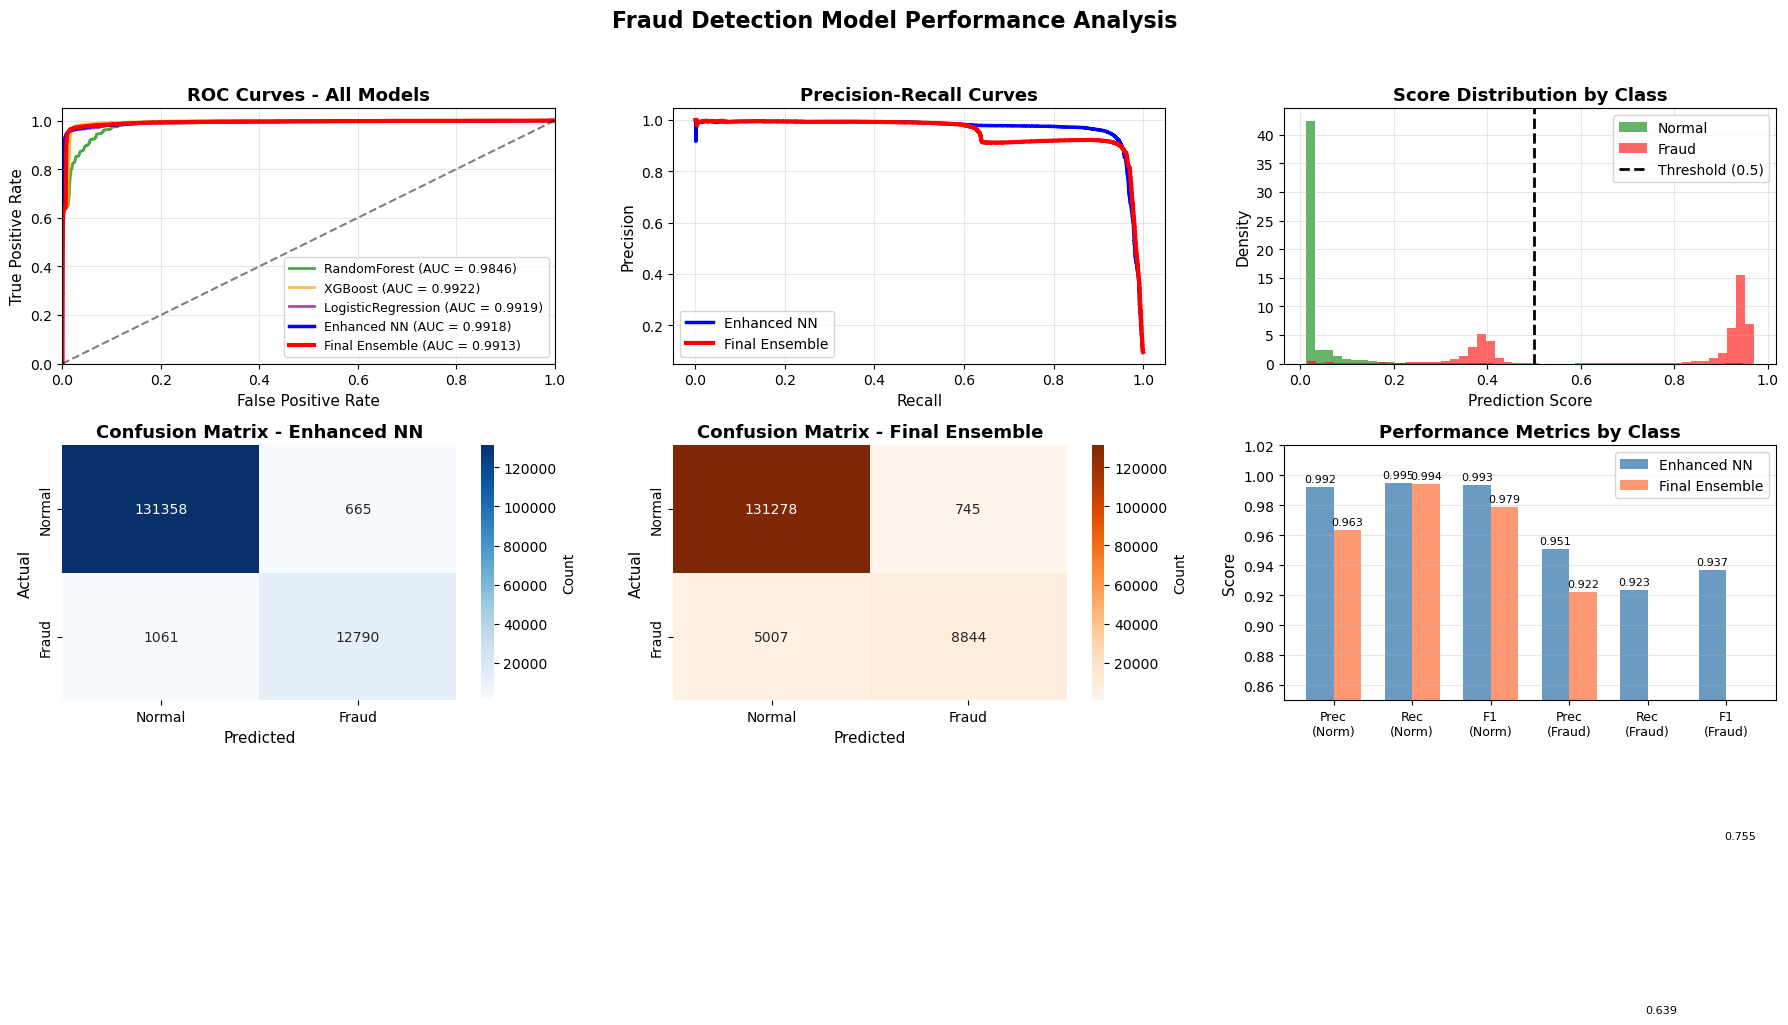


DETAILED PERFORMANCE METRICS

1. Classification Report - Enhanced Neural Network:
--------------------------------------------------
              precision    recall  f1-score   support

      Normal     0.9920    0.9950    0.9935    132023
       Fraud     0.9506    0.9234    0.9368     13851

    accuracy                         0.9882    145874
   macro avg     0.9713    0.9592    0.9651    145874
weighted avg     0.9881    0.9882    0.9881    145874


2. Classification Report - Final Ensemble:
--------------------------------------------------
              precision    recall  f1-score   support

      Normal     0.9633    0.9944    0.9786    132023
       Fraud     0.9223    0.6385    0.7546     13851

    accuracy                         0.9606    145874
   macro avg     0.9428    0.8164    0.8666    145874
weighted avg     0.9594    0.9606    0.9573    145874


3. Detailed Metrics Comparison:
--------------------------------------------------
Model                Class      P

In [12]:
metrics = analyze_saved_results()